In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import sbibm
import sbi_stacking.utils as utils
import sbi_stacking.stacking as stacking
import sbi_stacking.sbibm as sb

2023-10-13 15:18:12.781432: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-13 15:18:12.818615: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
nb_models = 50
nb_simulations = 1000   # Number of test simulations for stacking (N in the paper)
nb_epochs = 150
nb_freq_cpt = 10

task_name = "slcp"

device = "cuda:0"

In [15]:
params = {'text.usetex': True,
         'text.latex.preamble': r'\usepackage{amsmath}',
         "font.family": "serif", "font.serif": ["Computer Modern Roman"],
         'font.size': 15}
plt.rcParams.update(params)

In [9]:
task = sbibm.get_task(task_name)  # See sbibm.get_available_tasks() for all tasks
prior = task.get_prior()
simulator = task.get_simulator()

In [10]:
theta = prior(num_samples=nb_simulations)
x = simulator(theta)

theta = theta.to(device)
x = x.to(device)

print(x.shape, theta.shape)

torch.Size([1000, 8]) torch.Size([1000, 5])


In [11]:
runs = sb.get_sweep_runs(nb_models, f"npe_{task_name}_whist")

In [12]:
log_probs = torch.zeros((nb_models, nb_epochs//nb_freq_cpt, nb_simulations))
for epoch in range(nb_freq_cpt, nb_epochs + nb_freq_cpt, nb_freq_cpt):
    print("Epoch: {}".format(epoch))
    posteriors, _ = sb.get_sweep_runs_models(runs, epoch=epoch, device=device)
    for j in range(nb_models):
        log_probs[j, epoch//nb_freq_cpt-1, :] = posteriors[j].posterior_estimator.log_prob(theta, x).detach()

Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
Epoch: 60
Epoch: 70
Epoch: 80
Epoch: 90
Epoch: 100
Epoch: 110
Epoch: 120
Epoch: 130
Epoch: 140
Epoch: 150


In [13]:
n_it = 50

opt_weights_all = torch.zeros((nb_epochs//nb_freq_cpt, nb_models))

for epoch in range(nb_freq_cpt, nb_epochs + nb_freq_cpt, nb_freq_cpt):
    print("Epoch: {}".format(epoch))
    opt_weights = stacking.stacking_log_prob(log_probs[:, epoch//nb_freq_cpt-1, :], n_it)
    opt_weights_all[epoch//nb_freq_cpt-1, :] = opt_weights

Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
Epoch: 60
Epoch: 70
Epoch: 80
Epoch: 90
Epoch: 100
Epoch: 110
Epoch: 120
Epoch: 130
Epoch: 140
Epoch: 150


In [14]:
stacked_log_probs = torch.zeros((nb_epochs//nb_freq_cpt))
log_prob_unif = torch.zeros((nb_epochs//nb_freq_cpt))
for epoch in range(nb_freq_cpt, nb_epochs + nb_freq_cpt, nb_freq_cpt):
    print("Epoch: {}".format(epoch))
    weights = opt_weights_all[epoch//nb_freq_cpt-1, :]
    stacked_log_probs[epoch//nb_freq_cpt-1] = stacking.ensemble_log_prob(log_probs[:, epoch//nb_freq_cpt-1, :], weights).mean().item()

    # Compute log_probs for uniform weights
    uniform_weights = torch.ones(nb_models) / nb_models
    log_prob_unif[epoch//nb_freq_cpt-1] = stacking.ensemble_log_prob(log_probs[:, epoch//nb_freq_cpt-1, :], uniform_weights).mean().item()

Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
Epoch: 60
Epoch: 70
Epoch: 80
Epoch: 90
Epoch: 100
Epoch: 110
Epoch: 120
Epoch: 130
Epoch: 140
Epoch: 150


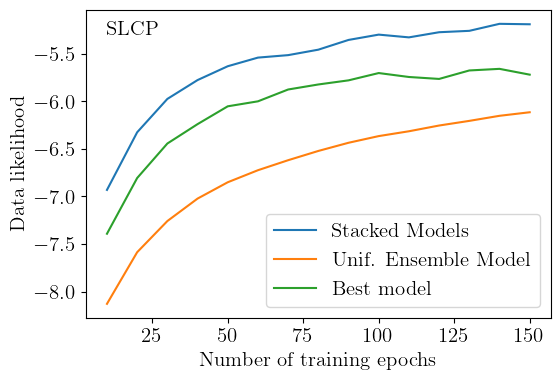

In [22]:
xvals = np.arange(nb_freq_cpt, nb_epochs + nb_freq_cpt, nb_freq_cpt)

plt.figure(figsize=(6, 4))
plt.plot(xvals, stacked_log_probs, label="Stacked")
plt.plot(xvals, log_prob_unif, label="Uniform")
plt.plot(xvals, log_probs[0].mean(dim=-1), label="Best")
plt.xlabel("Number of training epochs")
plt.ylabel("Log predictive density")
plt.text(10, -5.3, r"SLCP")
plt.legend()
plt.savefig(f"figs/{task_name}_log_prob_hist.pdf", bbox_inches="tight")